## Bloomburrow Modeling

1. Imports and data loading
2. Initial feature engineering and pre-calculation
3. First Neural Network attempt
4. Synergy feature development (should be moved to a separate file/script?)
5. NN refinement

### Imports / Data Loading

In [64]:
# Data Handling & Computation
import pandas as pd
import numpy as np
import os
import gc
from scipy.stats import pearsonr

# Machine Learning Models
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Metrics & Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#TODO clean this up

color_list = ["W", "U", "B", "R", "G"]
basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}

def get_blb_data():
    """Retrieves games data, prioritizing cached data, then Parquet, and finally CSV."""

    parquet_file = f"data/blb/games.parquet"

    if os.path.exists(parquet_file):
        print(f"Loading game data for Bloomburrow from Parquet file...")
        df = pd.read_parquet(parquet_file, engine='fastparquet')
        return df
    raise FileNotFoundError(f"No data blb parquet found")


In [3]:
# Actually represents GAME data at this point
decks_df = get_blb_data()

Loading game data for Bloomburrow from Parquet file...


In [4]:
# Identify columns to keep
columns_to_keep = ["draft_id", "rank", "main_colors", "splash_colors", "won"] + [
    col for col in decks_df.columns if col.startswith("deck_")
]

# Drop all other columns
decks_df = decks_df[columns_to_keep]
# Convert boolean values to integers (True = 1, False = 0)
decks_df["won"] = decks_df["won"].astype(int)

# Calculate wins and losses per draft ID
decks_df["wins"] = decks_df.groupby("draft_id")["won"].transform("sum")
decks_df["losses"] = decks_df.groupby("draft_id")["won"].transform("count") - decks_df["wins"]
# drop incomplete drafts and buggy drafts (8 wins, 4 losses e.g.)
decks_df = decks_df[decks_df["wins"].isin([7]) | decks_df["losses"].isin([3])]


In [5]:
num_main_changes = (
    decks_df.groupby("draft_id")["main_colors"]
    .nunique()
    .gt(1)  # True if more than one unique value
    .sum()  # Count occurrences
)
num_splash_changes = (
    decks_df.groupby("draft_id")["splash_colors"]
    .nunique()
    .gt(1)
    .sum()
)
print(f"Drafts with main color changes: {num_main_changes}")
print(f"Drafts with splash color changes: {num_splash_changes}")
# Calculate win rate
decks_df["win_rate"] = decks_df["wins"] / (decks_df["wins"] + decks_df["losses"])
decks_df = decks_df.drop_duplicates(subset=["draft_id"])
#TODO investigate any deck redesigns
decks_df.head(2)

Drafts with main color changes: 1306
Drafts with splash color changes: 1524


,draft_id,rank,main_colors,splash_colors,won,deck_Agate Assault,deck_Agate-Blade Assassin,deck_Alania's Pathmaker,"deck_Alania, Divergent Storm",deck_Artist's Talent,...,deck_Whiskervale Forerunner,deck_Wick's Patrol,"deck_Wick, the Whorled Mind",deck_Wildfire Howl,deck_Wishing Well,"deck_Ygra, Eater of All","deck_Zoraline, Cosmos Caller",wins,losses,win_rate
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,gold,BG,WR,1,0,0,0,0,0,...,0,0,0,0,0,1,0,6,3,0.666667
9,676ca08a6f5e49ae9aee978bd62c02b1,silver,UBG,WR,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3,3,0.500000


In [6]:
decks_df = decks_df[~((decks_df["losses"] == 3) & (decks_df["wins"] >= 7))]

# Count occurrences of each win-loss pair
win_loss_counts = decks_df.groupby(["wins", "losses"]).size().reset_index(name="count")

# Sort for readability
win_loss_counts = win_loss_counts.sort_values(["wins", "losses"], ascending=[False, True])

# Display the table
print("Win-Loss Distribution:")
print(win_loss_counts)


Win-Loss Distribution:
   wins  losses  count
7     7       0   2115
8     7       1   6294
9     7       2  10821
6     6       3   9570
5     5       3  13785
4     4       3  18295
3     3       3  22346
2     2       3  24530
1     1       3  22365
0     0       3  13086


In [7]:
decks_df.shape

(143207, 284)

In [8]:
file_path = f"data/blb/cards.csv"
print(f"Loading Scryfall data for blb from existing file...")
cards_df = pd.read_csv(file_path)
cards_df = cards_df.reset_index()
ratings_df = pd.read_csv("data/blb/card-ratings.csv")
ratings_df["GP WR"] = ratings_df["GP WR"].str.rstrip('%').astype(float) / 100
ratings_df.head(2)

Loading Scryfall data for blb from existing file...


,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Banishing Light,W,C,207601,3.17,53955,3.96,292583,89.4%,0.551,48910,54.0%,67596,57.0%,116506,55.7%,175185,54.7%,1.0pp
1,"Beza, the Bounding Spring",W,M,7230,1.46,4829,1.43,26113,87.6%,0.571,4508,62.2%,6233,62.7%,10741,62.5%,15368,53.3%,9.2pp


##### 17Lands Data Field Descriptions  
(Compiled with assistance from Microsoft Copilot, edited)

- **Name**: The card's name.  
- **Color**: The card's primary color identity.  
- **Rarity**: The card's rarity (Common, Uncommon, Rare, Mythic).  
- **# Seen**: Total instances of the card appearing in draft packs.  
- **ALSA (Average Last Seen At)**: The average pick number where the card is still available. Lower values indicate highly desirable picks.  
- **ATA (Average Taken At)**: The average pick number where the card is actually taken. Typically lower than ALSA.  
- **# GP (Games Played)**: Count of games where the card was included in a deck.  
- **% GP (Percentage of Games Played)**: When drafted, the percentage of games where the card was present in the deck
- **GP WR (Games Played Win Rate)**: Win rate in games where the card was included in a deck.  
- **# OH (Opening Hand Count)**: Number of games where the card appeared in the opening hand.  
- **OH WR (Opening Hand Win Rate)**: Win rate when the card is present in the opening hand.  
- **# GD (Games Drawn Count)**: Number of games where the card was drawn naturally.  
- **GD WR (Games Drawn Win Rate)**: Win rate in games where the card was drawn.  
- **# GIH (Games In Hand Count)**: Total games where the card was in hand at any point, including opening hand, drawn, or tutored.  
- **GIH WR (Games In Hand Win Rate)**: Win rate for games where the card was in hand at least once.  
- **# GNS (Games Not Seen Count)**: Games where the card was in the deck but never appeared in hand.  
- **GNS WR (Games Not Seen Win Rate)**: Win rate for games where the card was never seen.  
- **IWD (Improvement When Drawn)**: Estimated improvement in win percentage when the card is drawn. Needs further verification.  

Opening hand refers to "final" opening hand after mulligans.

### Feature Engineering/Pre-calculation

1. Removal score
2. Bomb score
3. Curve information and color encoding

##### Plotting and Correlation Analysis Tools

In [9]:
def plot_feature_vs_winrate(df, feature_name):
    """
    Plots the relationship between a feature and win rate.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing game data.
    feature_name (str): The name of the feature to plot against win rate.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[feature_name], df["win_rate"], alpha=0.5)
    plt.xlabel(feature_name)
    plt.ylabel("Win Rate")
    plt.title(f"{feature_name} vs Win Rate")
    plt.grid(True)
    m, b = np.polyfit(df[feature_name], df["win_rate"], 1)
    plt.plot(df[feature_name], m * df[feature_name] + b, color="red", linestyle="dashed")
    plt.show()

def calc_pearson_wrcorr(df, feature_name):
    """
    Calculates the Pearson correlation coefficient between a feature and win rate.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing game data.
    feature_name (str): The name of the feature to calculate correlation with win rate.
    
    Returns:
    float: Pearson correlation coefficient.
    """
    corr, p_value = pearsonr(df[feature_name], df["win_rate"])
    print(f"Pearson Correlation: {corr:.4f}")
    print(f"P-Value: {p_value:.4f}")


In [10]:
removal_file_path = "data/blb/cheap_removal.txt"
with open(removal_file_path, "r") as f:
    removal_cards = set(line.strip() for line in f)

# Filter the ratings DataFrame
removal_df = ratings_df[ratings_df["Name"].isin(removal_cards)][["Name", "Color", "Rarity", "ATA", "GP WR"]]

print(removal_df.head())

               Name Color Rarity   ATA  GP WR
0   Banishing Light     W      C  3.96  0.551
23     Parting Gust     W      U  5.38  0.534
26   Repel Calamity     W      U  4.76  0.554
44  Dazzling Denial     U      C  9.31  0.530
45   Dire Downdraft     U      C  8.86  0.541


In [11]:
def compute_removal_scores(df, removal_map):
    """
    Computes removal scores for each deck by iterating over identified removal cards 
    and applying the adjusted formula directly.

    Parameters:
    df (pd.DataFrame): The reduced dataset (one row per deck).
    removal_map (dict): A dictionary where keys are removal card names and values are GP WR scores.

    Returns:
    pd.Series: Removal scores for each deck.
    """
    
    # Initialize removal score column to zero
    removal_scores = pd.Series(0, index=df.index, dtype=float)

    # Iterate over the removal map
    for card_name, win_rate in removal_map.items():
        deck_col = f"deck_{card_name}"  # Column name for this card in the deck data

        if deck_col in df.columns:  
            # Apply formula where card count is nonzero
            removal_scores += df[deck_col] * max((win_rate - 0.53), 0)  # Floor contribution at 0

    return removal_scores

# Taken out removal that costs more than 4, or is overly conditional


# Apply function efficiently
decks_df["removal_score"] = compute_removal_scores(decks_df, removal_df.set_index("Name")["GP WR"].to_dict())
calc_pearson_wrcorr(decks_df, "removal_score")


Pearson Correlation: 0.0736
P-Value: 0.0000


##### Bomb Feature

In [12]:
# Filter bombs based on rarity and win rate threshold
bombs_df = ratings_df[(ratings_df["Rarity"].isin(["R", "M"])) & (ratings_df["GP WR"] >= 0.54)][["Name", "Color", "Rarity", "ATA", "GP WR"]]
bombs_map = bombs_df.set_index("Name")["GP WR"].to_dict()
bombs_df.head(5) # Listed in color order so we're seeing white

,Name,Color,Rarity,ATA,GP WR
1,"Beza, the Bounding Spring",W,M,1.43,0.571
5,Caretaker's Talent,W,R,2.66,0.557
11,Essence Channeler,W,R,2.35,0.546
17,Jackdaw Savior,W,R,2.22,0.550
27,Salvation Swan,W,R,1.99,0.549


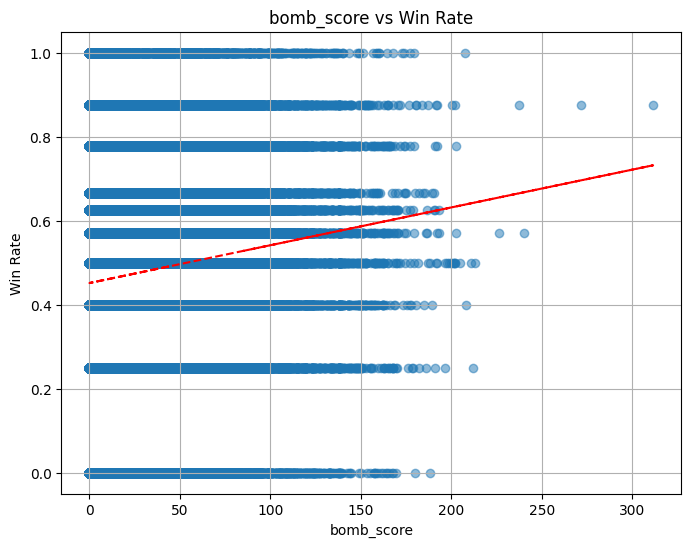

Pearson Correlation: 0.1151
P-Value: 0.0000


In [13]:
def compute_bomb_scores(df, bomb_map):
    """
    Computes bomb scores for each deck by iterating over identified bombs 
    and applying the formula directly.

    Parameters:
    df (pd.DataFrame): The reduced dataset (one row per deck).
    bomb_map (dict): A dictionary where keys are bomb card names and values are GP WR scores.

    Returns:
    pd.Series: Bomb scores for each deck.
    """
    
    # Initialize bomb score column to zero
    bomb_scores = pd.Series(0, index=df.index, dtype=float)

    # Iterate over the bomb map
    for card_name, win_rate in bomb_map.items():
        deck_col = f"deck_{card_name}"  # Column name for this card in the deck data

        if deck_col in df.columns:  
            # Apply formula where card count is nonzero
            bomb_scores += df[deck_col] * (((win_rate - 0.54) * 100) ** 3)

    return bomb_scores

# Compute bomb scores using preprocessed bomb_map
decks_df["bomb_score"] = compute_bomb_scores(decks_df, bombs_df.set_index("Name")["GP WR"].to_dict())
plot_feature_vs_winrate(decks_df, "bomb_score")
calc_pearson_wrcorr(decks_df, "bomb_score")


In [14]:
cards_df['index'].head()

0    0
1    1
2    2
3    3
4    4
Name: index, dtype: int64

In [15]:
# Precompute a bunch of things
land_names = set(cards_df.loc[cards_df["type_line"].str.contains("Land", na=False), "name"])
card_to_cmc = dict(zip(cards_df["name"], cards_df["cmc"]))
token_creators = {"Builder's Talent", "Carrot Cake", "Hop to It", "Otterball Antics", "Season of the Burrow", "Stormchaser's Talent"}
creature_names = set(cards_df.loc[cards_df["type_line"].str.contains("Creature", na=False), "name"])
gp_wr_map = dict(zip(ratings_df["Name"], ratings_df["GP WR"]))

def get_curve(row):
    """
    Extracts the mana curve from a deck row, excluding known land cards.

    - Uses deck_{cardname} columns to determine card counts.
    - References cards_df to get the CMC of each card.
    - Excludes cards already identified as lands.
    - Caps CMC at 6+, lumping high-cost cards together.
    
    Parameters:
    - row: A single row from the deck DataFrame.
    - cards_df: DataFrame containing card names and CMC values.
    - land_names: Precomputed set of land card names.

    Returns:
    - List of integers representing the mana curve.
    """
    curve = [0] * 7  # Index 0 = CMC 0, Index 6 = CMC 6+

    for col in row.index:
        if col.startswith("deck_"):
            card_name = col.split("_", 1)[1]  # Extract card name
            
            if card_name not in land_names:
                cmc = card_to_cmc.get(card_name, None)
                if cmc is not None:  # Ensure the card exists
                    cmc_value = min(int(cmc), 6)  # Cap CMC at 6+ (standard)
                    curve[cmc_value] += row[col]
    return curve


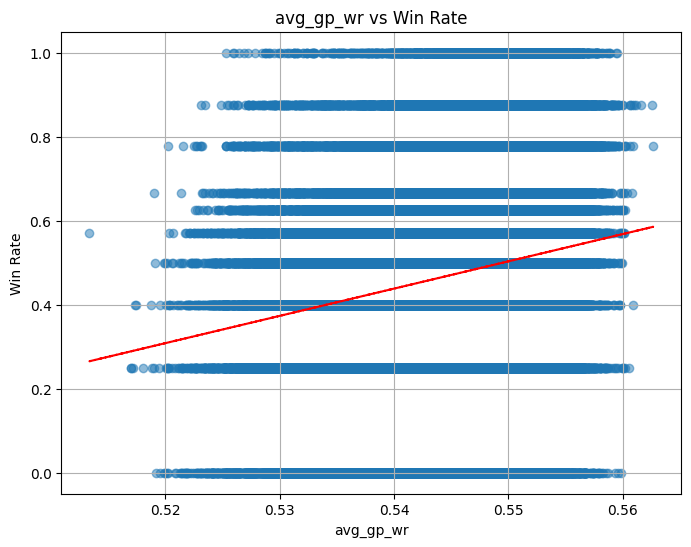

Pearson Correlation: 0.1720
P-Value: 0.0000


In [16]:
def compute_avg_gp_wr(df, gp_wr_map):
    """
    Computes the weighted average GP WR for each deck.

    Parameters:
    df (pd.DataFrame): Decks DataFrame with columns like 'deck_<card_name>'.
    gp_wr_map (dict): Dictionary of card names mapped to GP WR values.

    Returns:
    pd.Series: Weighted average GP WR for each deck.
    """
    
    # Extract all deck_* columns efficiently
    deck_cols = df.filter(like="deck_")

    # Remove basic lands & zero values
    filtered_cols = deck_cols.loc[:, ~deck_cols.columns.str.removeprefix("deck_").isin(basic_lands)]
    filtered_cols = filtered_cols.loc[:, (filtered_cols > 0).any(axis=0)]  # Keep only columns with nonzero values

    # Lookup GP WRs and compute weighted sum
    gp_wr_values = filtered_cols.columns.str.removeprefix("deck_").map(gp_wr_map).fillna(0)
    weighted_sums = filtered_cols.dot(gp_wr_values)

    return weighted_sums / filtered_cols.sum(axis=1)  # Compute weighted average

# Apply function efficiently
decks_df["avg_gp_wr"] = compute_avg_gp_wr(decks_df, gp_wr_map)

#TODO fix the data at the source... or somewhere.... (Frogmite, e.g.)
plot_feature_vs_winrate(decks_df, "avg_gp_wr")
calc_pearson_wrcorr(decks_df, "avg_gp_wr")


In [17]:
#Different structure because it's adding multiple columns
def add_cmc_columns(df):
    """
    Adds individual CMC columns to a DataFrame based on deck composition.

    Iterates through each row, calculates the mana curve, and assigns values 
    to separate CMC columns (cmc_0, cmc_1, ..., cmc_6).

    Parameters:
      df (pd.DataFrame): DataFrame containing deck data.

    Returns:
      pd.DataFrame: Updated DataFrame with CMC columns added.
    """
    cmc_columns = [f"cmc_{i}" for i in range(7)]
    
    # Initialize columns with zeros
    for col in cmc_columns:
        df[col] = 0

    def process_row(row):
        curve = get_curve(row)  # Generate curve once
        return dict(zip(cmc_columns, curve))  # Convert list to dict for Pandas efficiency

    # Apply function across all rows
    df[cmc_columns] = df.apply(process_row, axis=1).apply(pd.Series)

add_cmc_columns(decks_df)

In [18]:
# Calc Pearson correlation for each CMC column
cmc_cols = [f"cmc_{i}" for i in range(7)]  # cmc_0 to cmc_6

# Compute correlation for each column
for col in cmc_cols:
    print(f"Calculating correlation for {col}...")
    calc_pearson_wrcorr(decks_df, col)


Calculating correlation for cmc_0...
Pearson Correlation: nan
P-Value: nan
Calculating correlation for cmc_1...
Pearson Correlation: -0.0156
P-Value: 0.0000
Calculating correlation for cmc_2...
Pearson Correlation: 0.0650
P-Value: 0.0000
Calculating correlation for cmc_3...
Pearson Correlation: -0.0189
P-Value: 0.0000
Calculating correlation for cmc_4...
Pearson Correlation: -0.0323
P-Value: 0.0000
Calculating correlation for cmc_5...
Pearson Correlation: -0.0163
P-Value: 0.0000
Calculating correlation for cmc_6...
Pearson Correlation: 0.0031
P-Value: 0.2410


/tmp/ipykernel_10556/1867539562.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(df[feature_name], df["win_rate"])


In [19]:
def categorize_deck_colors(row):
    """
    Assigns a deck to one of 16 color categories based on `main_colors`.
    
    Parameters:
      row (pd.Series): A row from selected_games_df containing `main_colors`.
    
    Returns:
      str: The color category ("W", "WU", ..., "Multi").
    """
    active_colors = sorted(row["main_colors"])  # Sort for consistency
    
    if len(active_colors) == 1:
        return active_colors[0]  # Mono-color deck
    elif len(active_colors) == 2:
        return "".join(active_colors)  # Two-color deck
    else:
        return "Multi"  # Any deck with 3+ colors

# Apply function to categorize decks
decks_df["color_category"] = decks_df.apply(categorize_deck_colors, axis=1)

# One-hot encode the categories
color_categories = ["W", "U", "B", "R", "G", "WU", "WB", "WR", "WG", "UB", "UR", "UG", "BR", "BG", "RG", "Multi"]
for category in color_categories:
    decks_df[f"is_{category}"] = (decks_df["color_category"] == category).astype(int)

### Initial NN

We also had some Random Forest and XGBoost models; will likely return to those later for comparison.

In [20]:
# Define feature categories
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in decks_df.columns if col.startswith("deck_")]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr"] + cmc_cols + color_cols + deck_cols

# Extract only these columns
X = decks_df[features]
y = decks_df["win_rate"]

# This scaling is bad but we'll leave it for "history"
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_scaled.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),  # Regularization
    keras.layers.Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X_scaled, y, epochs=50, batch_size=64, validation_split=0.2, verbose=0)

/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1749761950.447833   10556 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749761950.451998   10556 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


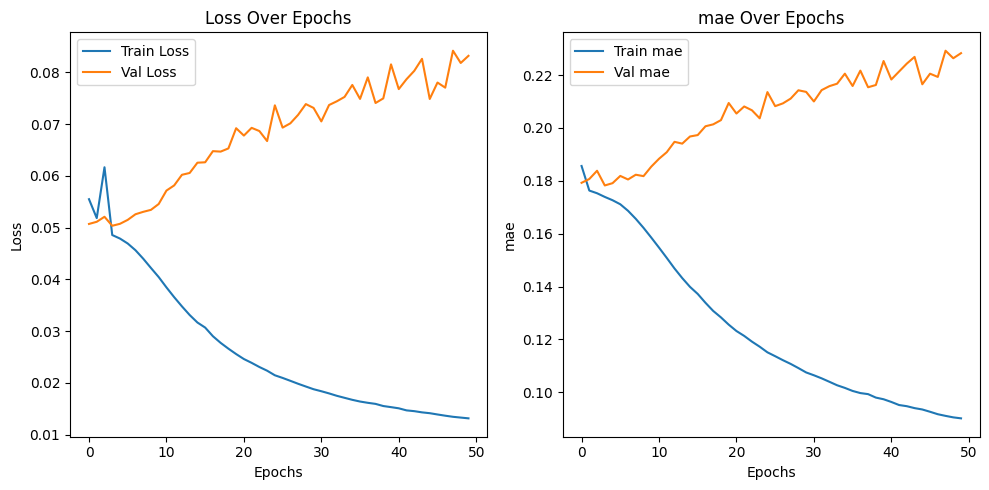

In [21]:
def plot_training_history(history, metric="mae"):
    """Plots training loss and MAE over epochs."""
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history[metric], label=f"Train {metric}")
    plt.plot(history[f"val_{metric}"], label=f"Val {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(model.history.history)


/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


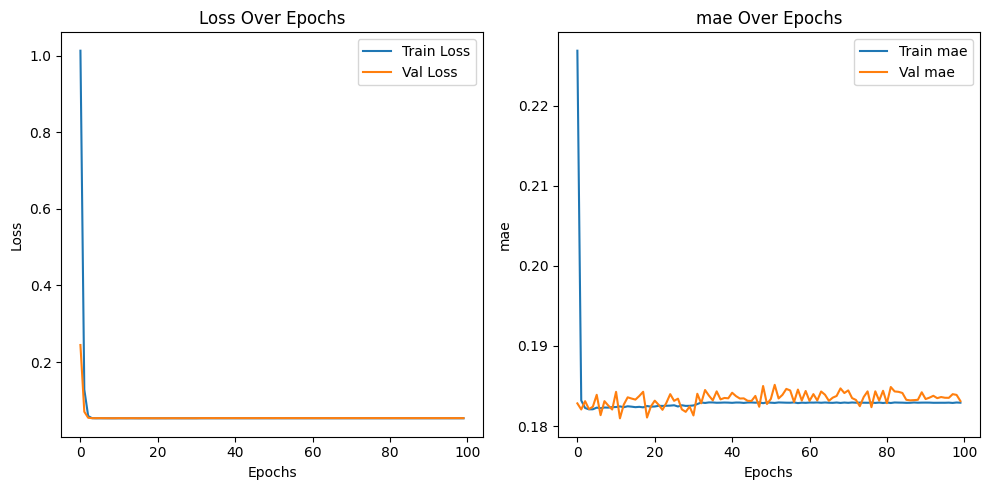

In [22]:
# ^^ Substantial overfitting - define MLP model with stronger regularization
model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),  # More dropout
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="linear")  # Regression output
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, verbose=0)
plot_training_history(model.history.history)
# vv Overfitting is fixed, but MAE is still too high

In [23]:
# Make predictions - it's already seen this data so big grain of salt
y_pred = model.predict(X)

# Compute R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

4476/4476 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step
R² Score: -0.0002


## Classification

Regression seems to be a struggle, so we'll experiment with a classification model to see if we can spot decks that did especially well (6 or 7 wins).

In [ ]:
def classify_medal_status(row):
    """Categorizes win count into medal tiers."""
    if row["wins"] == 7:
        return "medaled"
    elif row["wins"] == 6:
        return "almost medal"
    else:
        return "no medal"

# Apply classification
selected_games_df["medal_status"] = selected_games_df.apply(classify_medal_status, axis=1)
selected_games_df["medal_binary"] = (selected_games_df["wins"] >= 6).astype(int)
selected_games_df["medal_status"].value_counts()

In [ ]:

# Define Binary Classification Model
classification_mlp = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

# Stratified split to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(X, selected_games_df["medal_binary"], test_size=0.2, stratify=selected_games_df["medal_binary"], random_state=42)

# Compile classification_mlp for classification
classification_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train classification_mlp
classification_mlp.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)
plot_training_history(classification_mlp.history.history, metric="accuracy")

Epoch 1/100


c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7395 - loss: 5.0445 - val_accuracy: 0.8110 - val_loss: 2.4893
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 2.1689 - val_accuracy: 0.8110 - val_loss: 1.5142
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 1.3983 - val_accuracy: 0.8110 - val_loss: 1.1554
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 1.0969 - val_accuracy: 0.8110 - val_loss: 0.9760
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8061 - loss: 0.9346 - val_accuracy: 0.8110 - val_loss: 0.8410
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.8170 - val_accuracy: 0.8110 - val_loss: 0.7515
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8122 - loss: 0.7356 - val_accuracy: 0.8110 - val_loss: 0.6984
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - loss: 0.6678 - val_accuracy: 0.8110 - val_loss: 0.6

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


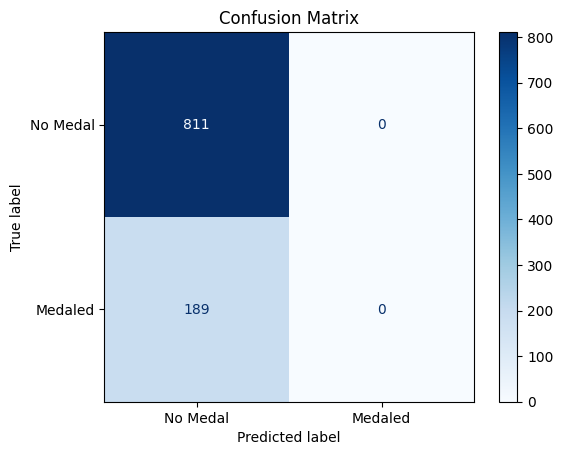

In [ ]:
# Get model predictions (rounded to 0 or 1)
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Medal", "Medaled"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
# Useless; just predicting majority class

### Synergy

Main logic moved into blb_synergy notebook. 

Temp section to load from file, calculate scores, and save

In [24]:
synergy_table = pd.read_parquet("data/blb/synergy_table_unf.parquet")
synergy_table.head()

games_together  wins_together  win_rate
card1 card2                                                         
Savor Druid of the Spade               3414           1990  0.582894
      Glidedive Duo                   23555          14141  0.600340
      Three Tree Rootweaver            8709           5187  0.595591
      Tender Wildguide                 2070           1296  0.626087
      Hazel's Nocturne                 9434           5784  0.613102

In [ ]:
# Extract deck columns
deck_columns = [col for col in decks_df.columns if col.startswith("deck_")]

def calculate_deck_synergy(row, synergy_table_filtered):
    """Computes synergy score for a single deck, excluding basic lands."""
    
    # Build card count dictionary (excluding basic lands)
    card_counts = {col.replace("deck_", ""): row[col] for col in deck_columns if row[col] > 0 and col.replace("deck_", "") not in basic_lands}

    deck_synergy = 0
    
    # Iterate over all unique card pairs
    card_list = list(card_counts.keys())
    for i, card1 in enumerate(card_list):
        for card2 in card_list[i+1:]:
            # Lookup synergy score (check both (card1, card2) and (card2, card1))
            try:
                synergy_score = synergy_table_filtered.xs((card1, card2))["synergy_score"]
            except KeyError:
                try:
                    synergy_score = synergy_table_filtered.xs((card2, card1))["synergy_score"]
                except KeyError:
                    synergy_score = 0  # Default to zero if pair isn't found


            # Scale synergy by card copies
            deck_synergy += synergy_score * card_counts[card1] * card_counts[card2]

    return deck_synergy

# Apply function to dataset
decks_df["card_synergy"] = decks_df.apply(calculate_deck_synergy, axis=1, args=(synergy_table,))
#TODO not very efficient
#synergy_dict = synergy_table_filtered["synergy_score"].to_dict()

calc_pearson_wrcorr(decks_df, "card_synergy")

In [33]:
synergy_table.head()

games_together  wins_together  win_rate  \
card1 card2                                                            
Savor Druid of the Spade               3414           1990  0.582894   
      Glidedive Duo                   23555          14141  0.600340   
      Three Tree Rootweaver            8709           5187  0.595591   
      Tender Wildguide                 2070           1296  0.626087   
      Hazel's Nocturne                 9434           5784  0.613102   

                             synergy_score  
card1 card2                                 
Savor Druid of the Spade          0.028394  
      Glidedive Duo               0.041340  
      Three Tree Rootweaver       0.042591  
      Tender Wildguide            0.062587  
      Hazel's Nocturne            0.056602

In [35]:
synergy_dict = synergy_table["synergy_score"].to_dict()

synergy_dict

{('Savor', 'Druid of the Spade'): 0.028393966022261297,
 ('Savor', 'Glidedive Duo'): 0.04133963065166635,
 ('Savor', 'Three Tree Rootweaver'): 0.04259076817085783,
 ('Savor', 'Tender Wildguide'): 0.06258695652173929,
 ('Savor', "Hazel's Nocturne"): 0.05660154759380964,
 ('Druid of the Spade', 'Glidedive Duo'): -0.01642111959287529,
 ('Druid of the Spade', 'Three Tree Rootweaver'): -0.027142654922931886,
 ('Druid of the Spade', 'Tender Wildguide'): 0.04508998988877655,
 ('Druid of the Spade', "Hazel's Nocturne"): 0.00488141391106045,
 ('Glidedive Duo', 'Three Tree Rootweaver'): 0.021133288074224876,
 ('Glidedive Duo', 'Tender Wildguide'): 0.06391054613935965,
 ('Glidedive Duo', "Hazel's Nocturne"): 0.025172587329781004,
 ('Three Tree Rootweaver', 'Tender Wildguide'): 0.04680861093651789,
 ('Three Tree Rootweaver', "Hazel's Nocturne"): 0.042757016248153645,
 ('Tender Wildguide', "Hazel's Nocturne"): 0.059254237288135614,
 ('Savor', 'Cache Grab'): 0.05804638385545979,
 ('Savor', 'Bakersba

In [36]:
del synergy_table
gc.collect()

16530

In [39]:
def calculate_deck_synergy(row, synergy_dict):
    """Computes synergy score for a single deck, excluding basic lands."""
    
    # Build card count dictionary (excluding basic lands)
    card_counts = {col.replace("deck_", ""): row[col] for col in deck_cols if row[col] > 0 and col.replace("deck_", "") not in basic_lands}

    deck_synergy = 0
    
    # Iterate over all unique card pairs
    card_list = list(card_counts.keys())
    for i, card1 in enumerate(card_list):
        for card2 in card_list[i+1:]:
            # Use dictionary lookup instead of .xs()
            synergy_score = synergy_dict.get((card1, card2), 0)

            # Scale synergy by card copies
            deck_synergy += synergy_score * card_counts[card1] * card_counts[card2]

    return deck_synergy

# Apply function using the optimized dictionary
decks_df["card_synergy"] = decks_df.apply(calculate_deck_synergy, axis=1, args=(synergy_dict,))


In [41]:
decks_df.to_parquet("data/blb/decks_w_features.parquet")

### NN Using Synergy

/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.9146 - mae: 0.3004 - val_loss: 0.1599 - val_mae: 0.1869
Epoch 2/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1149 - mae: 0.1828 - val_loss: 0.0593 - val_mae: 0.1835
Epoch 3/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0566 - mae: 0.1823 - val_loss: 0.0540 - val_mae: 0.1808
Epoch 4/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0538 - mae: 0.1826 - val_loss: 0.0536 - val_mae: 0.1821
Epoch 5/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0531 - mae: 0.1816 - val_loss: 0.0541 - val_mae: 0.1800
Epoch 6/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0535 - mae: 0.1826 - val_loss: 0.0535 - val_mae: 0.1824
Epoch 7/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0533 - mae: 0.1823 - val_loss: 0.0537 - val_mae: 0.1840
Epoch 8/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0532 - mae: 0.1822 - val_loss: 0.0535 - val_mae: 0.1827
Epoch 9/30
1791/1791 ━━━━━━━━━━━━━━━━━━━

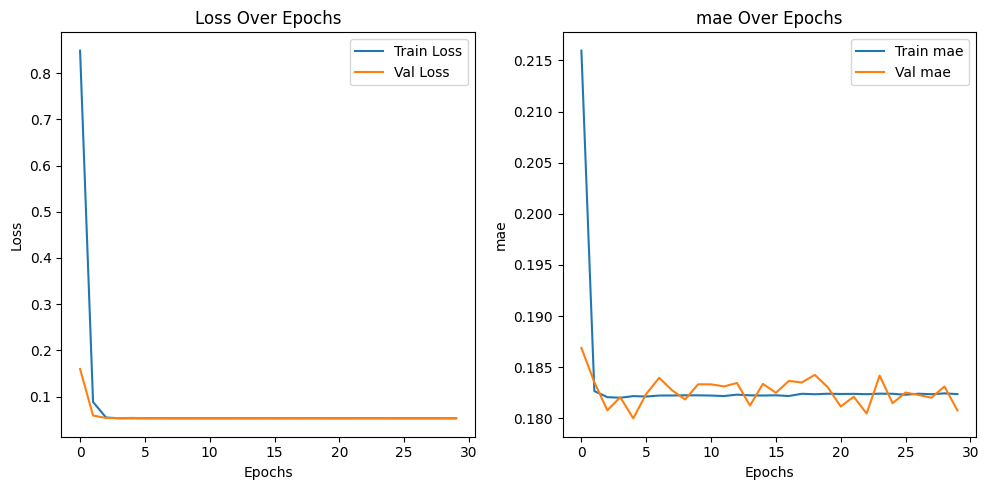

In [43]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in decks_df.columns if col.startswith("deck_")]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"] + cmc_cols + color_cols + deck_cols

# Extract only these columns
X = decks_df[features]
y = decks_df["win_rate"]

model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),  # More dropout
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="linear")  # Regression output
])

# Compile model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model for longer
model.fit(X, y, epochs=30, batch_size=64, validation_split=0.2, verbose=1)

plot_training_history(model.history.history)

In [44]:
y_pred = model.predict(X)

# Compute R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

4476/4476 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step
R² Score: 0.0092


In [ ]:
X = decks_df[features].copy()
y = decks_df["win_rate"]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"] + cmc_cols + color_cols + deck_cols
# Perform train-test split first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Select scaling method (standard, minmax, or none) inside `build_model()`
def scale_features(X_train, X_val, hp):
    scaler_type = hp.Choice("scaling", ["standard", "minmax", "none"])
    
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        return X_train, X_val  # No scaling
    
    # Apply scaling only to selected features
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()

    X_train_scaled[scale_features_list] = scaler.fit_transform(X_train[scale_features_list])
    X_val_scaled[scale_features_list] = scaler.transform(X_val[scale_features_list])  # Use transform only!
    
    return X_train_scaled, X_val_scaled

# Extract only these columns
#X = selected_games_df.loc[:, features]  # Ensure explicit selection

hp = HyperParameters()
scale_features_list = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]

def build_model(hp):
    """Creates a neural network with tunable hyperparameters, including feature scaling."""
    model = keras.Sequential()

    # Choose feature scaling method
    scaler_type = hp.Choice("scaling", ["standard", "minmax", "none"])
    
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None  # No scaling

    # Apply scaling only to selected features if applicable
    X_train_scaled = X_train.copy()
    if scaler:
        X_train_scaled[scale_features_list] = scaler.fit_transform(X_train[scale_features_list])

    # Input Layer
    model.add(keras.layers.Dense(512, activation=hp.Choice("activation", ["relu", "leaky_relu", "elu"]),
                                 kernel_regularizer=keras.regularizers.l2(hp.Float("l2", 0.001, 0.01, step=0.001)),
                                 input_shape=(X_train_scaled.shape[1],)))
    model.add(keras.layers.Dropout(hp.Float("dropout", 0.1, 0.4, step=0.05)))

    # Hidden Layers
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(64, activation="relu"))

    model.add(keras.layers.Dropout(hp.Float("dropout", 0.1, 0.4, step=0.05)))  # Final dropout before output

    # Output Layer
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compile with tunable optimizer
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "nadam", "rmsprop"], default="adam"),
                  loss=keras.losses.MSE,
                  metrics=["mae"])
    
    return model

# Define random search tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,  # Number of configurations to test
    executions_per_trial=1,  # Each setting runs once
    directory="nn_tuning",
    project_name="synergy_nn"
)

X_train_scaled, X_val_scaled = scale_features(X_train, X_val, hp)

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), batch_size=hp.Choice("batch_size", [32, 64, 128]), verbose=1)


Trial 20 Complete [00h 00m 17s]
val_loss: 0.06051138415932655

Best val_loss So Far: 0.05988107621669769
Total elapsed time: 00h 05m 04s


In [13]:
best_trial = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Trial:")
print(f"  Scaling: {best_trial.get('scaling')}")
print(f"  Activation: {best_trial.get('activation')}")
print(f"  L2 Regularization: {best_trial.get('l2')}")
print(f"  Dropout Rate: {best_trial.get('dropout')}")
print(f"  Optimizer: {best_trial.get('optimizer')}")


Best Trial:
  Scaling: minmax
  Activation: leaky_relu
  L2 Regularization: 0.001
  Dropout Rate: 0.35
  Optimizer: rmsprop


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
y_pred = best_model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


R² Score: 0.0712
MAE: 0.1897


## Further nn refinement

In [46]:
# Apply MinMax scaling to relevant features
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

scale_features_list = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]
X_train_scaled[scale_features_list] = scaler.fit_transform(X_train[scale_features_list])
X_val_scaled[scale_features_list] = scaler.transform(X_val[scale_features_list])

# Build the model manually based on best trial results
model = keras.Sequential()

# Input Layer
model.add(keras.layers.Dense(512, activation="leaky_relu",
                             kernel_regularizer=keras.regularizers.l2(0.001),
                             input_shape=(X_train_scaled.shape[1],)))
model.add(keras.layers.Dropout(0.35))  # Best dropout rate

# Hidden Layers
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))

model.add(keras.layers.Dropout(0.35))  # Final dropout before output

# Output Layer
model.add(keras.layers.Dense(1, activation="linear"))

# Compile using best optimizer
model.compile(optimizer="rmsprop",
              loss=keras.losses.MSE,
              metrics=["mae"])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), batch_size=64, verbose=1)

/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1490 - mae: 0.2055 - val_loss: 0.0542 - val_mae: 0.1787
Epoch 2/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0541 - mae: 0.1830 - val_loss: 0.0555 - val_mae: 0.1889
Epoch 3/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0533 - mae: 0.1813 - val_loss: 0.0532 - val_mae: 0.1781
Epoch 4/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0532 - mae: 0.1810 - val_loss: 0.0528 - val_mae: 0.1814
Epoch 5/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0530 - mae: 0.1802 - val_loss: 0.0521 - val_mae: 0.1771
Epoch 6/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0529 - mae: 0.1800 - val_loss: 0.0523 - val_mae: 0.1803
Epoch 7/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0528 - mae: 0.1800 - val_loss: 0.0528 - val_mae: 0.1824
Epoch 8/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0529 - mae: 0.1805 - val_loss: 0.0518 - val_mae: 0.1779
Epoch 9/50
1791/1791 ━━━━━━━━━━━━━━━━━━━

In [52]:
y_pred = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step
R² Score: 0.0394
MAE: 0.1793


In [47]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

def test_narrow_model(X, y, eng_feat_mult, base_width):
    """
    Creates and trains a narrow, deep neural network with early stopping and engineered feature scaling.

    Parameters:
    X (pd.DataFrame): Feature dataset.
    y (pd.Series): Target variable (win rate).
    eng_feat_mult (float): Multiplier for engineered features.
    base_width (int): Width of the final layer (determines depth).
    
    Returns:
    Trained model.
    """
    
    # Apply MinMax scaling to relevant features
    scale_features_list = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]
    
    scaler = MinMaxScaler()
    X_scaled = X.copy()
    X_scaled[scale_features_list] = scaler.fit_transform(X_scaled[scale_features_list]) * eng_feat_mult  # Apply multiplier

    # Define layer widths based on base_width
    layer_sizes = [base_width * 8, base_width * 4, base_width * 2, base_width]  # Deep structure

    model = keras.Sequential()

    # Input Layer
    model.add(keras.layers.Dense(layer_sizes[0], activation="relu",
                                 kernel_regularizer=keras.regularizers.l2(0.001),
                                 input_shape=(X_scaled.shape[1],)))
    model.add(keras.layers.Dropout(0.35))

    # Hidden Layers
    for size in layer_sizes[1:]:  # Iterate over computed sizes
        model.add(keras.layers.Dense(size, activation="relu"))
        model.add(keras.layers.Dense(size, activation="relu"))

    model.add(keras.layers.Dropout(0.35))  # Final dropout before output

    # Output Layer
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compile model
    model.compile(optimizer="rmsprop",
                  loss=keras.losses.MSE,
                  metrics=["mae"])

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train model
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=64, verbose=1,
              callbacks=[early_stopping])

    return model

narrow_model = test_narrow_model(X, y, 10, 16)

/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1119 - mae: 0.2086 - val_loss: 0.0523 - val_mae: 0.1749
Epoch 2/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0520 - mae: 0.1787 - val_loss: 0.0512 - val_mae: 0.1765
Epoch 3/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0515 - mae: 0.1779 - val_loss: 0.0511 - val_mae: 0.1777
Epoch 4/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0513 - mae: 0.1773 - val_loss: 0.0517 - val_mae: 0.1806
Epoch 5/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0519 - mae: 0.1788 - val_loss: 0.0508 - val_mae: 0.1747
Epoch 6/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0519 - mae: 0.1786 - val_loss: 0.0506 - val_mae: 0.1765
Epoch 7/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0516 - mae: 0.1783 - val_loss: 0.0510 - val_mae: 0.1753
Epoch 8/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0514 - mae: 0.1775 - val_loss: 0.0522 - val_mae: 0.1818
Epoch 9/50
1791/1791 ━━━━━━━━━━━━━━━━━━━

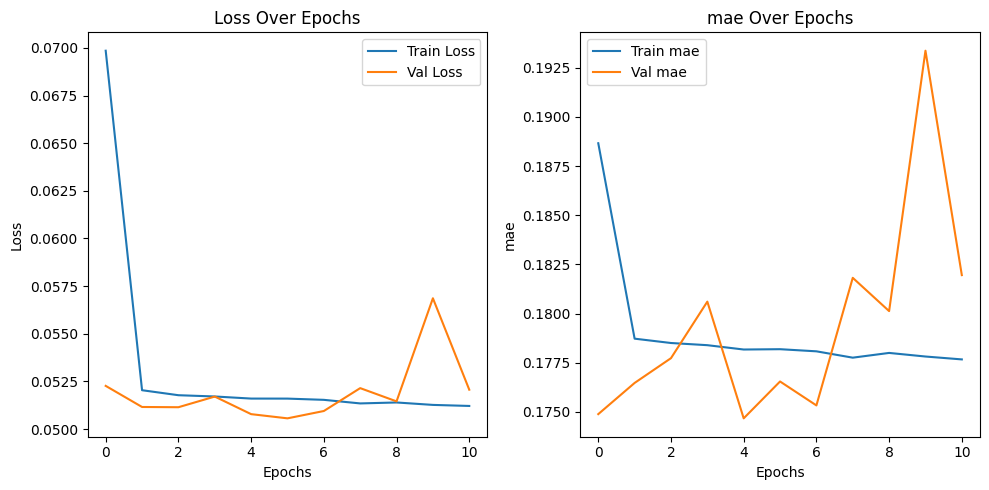

In [48]:
plot_training_history(narrow_model.history.history)

In [ ]:
# Reapply MinMax scaling with the same transformation
scaler = MinMaxScaler()
X_scaled_test = X.copy()
X_scaled_test[scale_features_list] = scaler.fit_transform(X_scaled_test[scale_features_list]) * 10  # Match scaling method

# Make predictions
y_pred = model.predict(X_scaled_test)

# Compute R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")


4476/4476 ━━━━━━━━━━━━━━━━━━━━ 3s 571us/step
R² Score: -0.1878


ValueError: Found input variables with inconsistent numbers of samples: [28642, 143207]

In [50]:
mae = mean_absolute_error(y, y_pred)
print(f"mae: {mae}")

mae: 0.19196641555964392


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Initialize model with reasonable defaults
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)

# Compute R² score
r2 = r2_score(y_val, y_pred)
print(f"Random Forest R² Score: {r2:.4f}")


Random Forest R² Score: 0.0688


In [55]:
mae = mean_absolute_error(y_val, y_pred)
print(f"mae: {mae}")

mae: 0.17501089056078953


## rf vs nn head to head

In [56]:
# Identify basic land columns dynamically
basic_land_columns = [col for col in X.columns if any(land in col for land in ["Plains", "Island", "Swamp", "Mountain", "Forest"])]

# Scale only basic lands
X_prepared = X.copy()
X_prepared[basic_land_columns] = X_prepared[basic_land_columns] / 10

X_train, X_val, y_train, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

In [57]:
# Initialize Random Forest with specified parameters
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)

# Compute R² score
r2 = r2_score(y_val, y_pred)
print(f"Random Forest R² Score: {r2:.4f}")

Random Forest R² Score: 0.0688


In [58]:
# Build the neural network (fat_nn_model) without scaling
fat_nn_model = keras.Sequential()

# Wide first layer
fat_nn_model.add(keras.layers.Dense(1024, activation="relu",
                                    kernel_regularizer=keras.regularizers.l2(0.001),
                                    input_shape=(X_train.shape[1],)))
fat_nn_model.add(keras.layers.Dropout(0.5))  # High dropout on first layer

# Hidden Layers (progressively narrowing)
fat_nn_model.add(keras.layers.Dense(512, activation="relu"))
fat_nn_model.add(keras.layers.Dense(256, activation="relu"))
fat_nn_model.add(keras.layers.Dense(128, activation="relu"))
fat_nn_model.add(keras.layers.Dense(64, activation="relu"))

fat_nn_model.add(keras.layers.Dropout(0.35))  # Final dropout before output

# Output Layer
fat_nn_model.add(keras.layers.Dense(1, activation="linear"))

# Compile model with lower learning rate
fat_nn_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
                     loss=keras.losses.MSE,
                     metrics=["mae"])

# Train model for 30 epochs, verbose=1
fat_nn_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=64, verbose=1)

# Compute R² score
y_pred_nn = fat_nn_model.predict(X_val)
r2_nn = r2_score(y_val, y_pred_nn)
print(f"Fat NN R² Score: {r2_nn:.4f}")

/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.2419 - mae: 0.2255 - val_loss: 0.0523 - val_mae: 0.1789
Epoch 2/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0534 - mae: 0.1813 - val_loss: 0.0513 - val_mae: 0.1782
Epoch 3/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0523 - mae: 0.1792 - val_loss: 0.0508 - val_mae: 0.1771
Epoch 4/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0516 - mae: 0.1780 - val_loss: 0.0506 - val_mae: 0.1747
Epoch 5/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0512 - mae: 0.1774 - val_loss: 0.0505 - val_mae: 0.1756
Epoch 6/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0511 - mae: 0.1771 - val_loss: 0.0507 - val_mae: 0.1784
Epoch 7/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0510 - mae: 0.1769 - val_loss: 0.0505 - val_mae: 0.1749
Epoch 8/30
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0511 - mae: 0.1770 - val_loss: 0.0503 - val_mae: 0.1756
Epoch 9/30
1791/1791 ━━━━━━━━━━━━

In [60]:
# MAE for RF
mae = mean_absolute_error(y_val, y_pred)
print(f"mae: {mae}")

mae: 0.17501075133228788


In [62]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Initialize XGBoost with reasonable hyperparameters
xgb_model = XGBRegressor(
    n_estimators=500,  # More trees for stability
    max_depth=6,  # Balanced complexity
    learning_rate=0.05,  # Lower than default for smoother convergence
    subsample=0.8,  # Slightly reduced to help generalization
    colsample_bytree=0.8,  # Similar effect for feature selection
    random_state=42,
    n_jobs=-1  # Parallel processing for speed
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_val)

# Compute metrics
r2_xgb = r2_score(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print(f"XGBoost R² Score: {r2_xgb:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")


XGBoost R² Score: 0.0798
XGBoost MAE: 0.1741


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Define engineered feature set
engineered_features = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]

# Extract relevant data
X_train_lr = X_train[engineered_features]
X_val_lr = X_val[engineered_features]

# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_lr, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_val_lr)

# Compute metrics
r2_lr = r2_score(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)

print(f"Linear Regression R² Score: {r2_lr:.4f}")
print(f"Linear Regression MAE: {mae_lr:.4f}")


Linear Regression R² Score: 0.0419
Linear Regression MAE: 0.1776


## Clustering

This is an interesting experiment in its own right - can a clustering algorithm find the 10 main tribal archetypes? For our first approach we will keep it super simple, only including 2 color decks and asking for 10 clusters.

We will use the clustering approach to find more specifics on what cards/features are win predictive within a cluster. Examples:
 - Red/white mice probably does best with a very low curve, plenty of 1-2 drops. Most other decks don't want this
 - Blue/red otters definitely needs a good number of non-creature spells, but this is a detriment in other archetypes

In [16]:
decks2c_df = selected_games_df[selected_games_df["main_colors"].apply(lambda x: len(x) == 2)].copy()
decks2c_df['main_colors'].value_counts()

main_colors
BG    820
WG    684
UG    597
WB    567
WR    459
BR    427
RG    372
UB    352
UR    220
WU    144
Name: count, dtype: int64

In [ ]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
deck_cols = [col for col in decks2c_df.columns if col.startswith("deck_")]

cluster_features = cmc_cols + deck_cols

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
decks2c_df["cluster"] = kmeans.fit_predict(decks2c_df[cluster_features])


In [18]:
cluster_color_counts = decks2c_df.groupby("cluster")["main_colors"].value_counts().reset_index(name="count")
# Find the most common main_colors for each cluster
top_colors_df = cluster_color_counts.loc[cluster_color_counts.groupby("cluster")["count"].idxmax()].copy()

# Compute percentage within cluster
total_per_cluster = decks2c_df["cluster"].value_counts()
top_colors_df["percentage"] = top_colors_df.apply(lambda row: row["count"] / total_per_cluster[row["cluster"]] * 100, axis=1)

# Display results
print(top_colors_df[["cluster", "main_colors", "percentage"]])


    cluster main_colors  percentage
0         0          WG  100.000000
1         1          UB   69.367589
4         2          BG  100.000000
5         3          UG   74.253731
9         4          BR   99.533800
12        5          RG   99.731903
14        6          WB  100.000000
15        7          WR   99.782135
17        8          WG  100.000000
18        9          BG   99.768519


## Clustering Feature building

In [90]:
# Establish baselines
# List of features to average
feature_columns = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]
cmc_columns = [col for col in decks_df.columns if col.startswith("cmc_")]

# Compute averages for selected features
def get_feature_avgs(df):

    baseline_averages = df[feature_columns + cmc_columns].mean()

    # Compute overall average win rate
    total_wins = df["wins"].sum()
    total_losses = df["losses"].sum()
    average_win_rate = total_wins / (total_wins + total_losses)

    # Display results
    print("Feature Averages:")
    print(baseline_averages)
    print(f"Average Win Rate: {average_win_rate:.4f}")
    return baseline_averages, average_win_rate

print("Baseline")
baseline_avgs, baseline_wr = get_feature_avgs(decks_df)

Baseline
Feature Averages:
removal_score     0.053391
bomb_score       26.636807
avg_gp_wr         0.545692
card_synergy      5.630541
cmc_0             0.000000
cmc_1             2.516295
cmc_2             8.514451
cmc_3             6.238361
cmc_4             3.410015
cmc_5             1.953368
cmc_6             0.650087
dtype: float64
Average Win Rate: 0.5417


##### Hypotheses for Mice

- Higher CMC 1 and 2, lower 5 and 6
- Win rate constant, maybe a slight bump
- No strong expectations on engineered features

In [91]:
mice_df = decks_df[decks_df['main_colors'] == "WR"]

print("Mice")
mice_avgs, mice_wr = get_feature_avgs(mice_df)

Mice
Feature Averages:
removal_score     0.040372
bomb_score       30.362675
avg_gp_wr         0.544906
card_synergy      0.930238
cmc_0             0.000000
cmc_1             3.979275
cmc_2             8.921073
cmc_3             6.370431
cmc_4             2.742352
cmc_5             1.473632
cmc_6             0.003407
dtype: float64
Average Win Rate: 0.5412


In [92]:
mice_deltas = mice_avgs - baseline_avgs
print("Mice minus baseline")
print(mice_deltas)

Mice minus baseline
removal_score   -0.013019
bomb_score       3.725868
avg_gp_wr       -0.000786
card_synergy    -4.700303
cmc_0            0.000000
cmc_1            1.462980
cmc_2            0.406622
cmc_3            0.132070
cmc_4           -0.667663
cmc_5           -0.479736
cmc_6           -0.646680
dtype: float64


The deck does not seem as reliant on our current definition of synergy. As expected, small tick upward on low CMCs. The format is already fast, so there's not a huge amount of "room" there.

Let's look at top quartile mice decks and see if there are any distinguishing patterns in these numbers.

In [93]:
win_rate_threshold = decks_df["wins"] / (decks_df["wins"] + decks_df["losses"])
top_quartile_cutoff = win_rate_threshold.quantile(0.75)  # Get the 75th percentile value

# Filter the dataset for top-quartile decks
top_quartile_df = decks_df[win_rate_threshold >= top_quartile_cutoff]
top_mice_df = top_quartile_df[top_quartile_df["main_colors"] == "WR"]
print("Winning Mice")
winning_mice_avgs, winning_mice_wr = get_feature_avgs(top_mice_df)

Winning Mice
Feature Averages:
removal_score     0.041792
bomb_score       36.773899
avg_gp_wr         0.545705
card_synergy      1.326362
cmc_0             0.000000
cmc_1             3.978261
cmc_2             9.040612
cmc_3             6.407310
cmc_4             2.649068
cmc_5             1.411610
cmc_6             0.003344
dtype: float64
Average Win Rate: 0.7235


In [94]:
winning_deltas = winning_mice_avgs - mice_avgs
print("Winning mice minus mice")
print(winning_deltas)

Winning mice minus mice
removal_score    0.001420
bomb_score       6.411224
avg_gp_wr        0.000799
card_synergy     0.396124
cmc_0            0.000000
cmc_1           -0.001014
cmc_2            0.119538
cmc_3            0.036879
cmc_4           -0.093284
cmc_5           -0.062022
cmc_6           -0.000062
dtype: float64


Interesting. Top mice decks:
- Win more often (haha)
- Include fewer 1 drops and aren't as afraid of higher CMC cards
- Lean much more into synergy

Short diversion to check the top quartile avg_gp_wr. WR mice seems likely to buck the overall trend, because we've previously established that this feature is correlated with winning.

In [95]:
print("Top Quartile Decks")
top_quartile_avgs, top_quartile_wr = get_feature_avgs(top_mice_df)

Top Quartile Decks
Feature Averages:
removal_score     0.041792
bomb_score       36.773899
avg_gp_wr         0.545705
card_synergy      1.326362
cmc_0             0.000000
cmc_1             3.978261
cmc_2             9.040612
cmc_3             6.407310
cmc_4             2.649068
cmc_5             1.411610
cmc_6             0.003344
dtype: float64
Average Win Rate: 0.7235


In [97]:
print("Top decks minus baseline (all)")
top_delta = top_quartile_avgs - baseline_avgs
print(top_delta)

Top decks minus baseline (all)
removal_score    -0.011599
bomb_score       10.137092
avg_gp_wr         0.000013
card_synergy     -4.304179
cmc_0             0.000000
cmc_1             1.461966
cmc_2             0.526160
cmc_3             0.168949
cmc_4            -0.760947
cmc_5            -0.541758
cmc_6            -0.646742
dtype: float64


In [101]:
# Count occurrences, including empty splash colors
mice_splash_dist = mice_df["splash_colors"].fillna("None").value_counts(normalize=True) * 100
top_mice_splash_dist = top_mice_df["splash_colors"].fillna("None").value_counts(normalize=True) * 100

# Combine results into a DataFrame
splash_comparison = pd.DataFrame({
    "All WR Mice Decks": mice_splash_dist,
    "Top WR Mice Decks": top_mice_splash_dist
}).fillna(0).round(2)  # Fill missing values with 0 and round to 2 decimal places

# Display results
splash_comparison


,All WR Mice Decks,Top WR Mice Decks
splash_colors,,
B,7.24,6.16
BG,2.31,2.08
G,9.03,9.10
None,67.68,70.02
U,7.77,7.41
UB,2.23,2.48
UBG,0.94,0.67
UG,2.79,2.08


## Archetype Splash Score

In [105]:
archetype_list = [
    "W", "U", "B", "R", "G",  # Single-color archetypes
    "WU", "WB", "WR", "WG", "UB", "UR", "UG", "BR", "BG", "RG"  # Dual-color archetypes
]


# Define dictionary to store splash differences by archetype
splash_effects = {}

# Iterate over single and dual color clusters
for archetype in archetype_list:  # Ensure archetype_list contains all valid clusters (excluding rainbow)
    # Get splash distributions for this archetype
    archetype_splash_dist = decks_df[decks_df["main_colors"] == archetype]["splash_colors"].value_counts(normalize=True) * 100
    top_archetype_splash_dist = top_quartile_df[top_quartile_df["main_colors"] == archetype]["splash_colors"].value_counts(normalize=True) * 100
    
    # Compute splash prevalence difference
    splash_diff = (top_archetype_splash_dist - archetype_splash_dist).fillna(0)

    # Store results in dictionary
    splash_effects[archetype] = splash_diff.to_dict()

# Output splash effects dictionary
print(splash_effects)


{'W': {'B': -0.3995886091955967, 'BG': -2.909241118848106, 'BR': 0.0, 'BRG': 0.6988585591205672, 'G': 4.72677918092765, 'R': 0.8784205290755516, 'RG': 0.33130447977609556, 'U': 0.4139198462342568, 'UB': -0.22508472290131643, 'UBG': -1.3328050445954376, 'UBR': -0.9146701286439278, 'UBRG': -0.2849387128863111, 'UG': -0.15595757953836564, 'UR': 0.4046466928562995, 'URG': -0.4594425991805906}, 'U': {'B': 0.30684754521963953, 'BG': 7.0090439276485785, 'BR': -1.146640826873385, 'BRG': 1.873385012919897, 'G': -8.785529715762273, 'R': 9.366925064599481, 'RG': 2.3578811369509047, 'W': -9.93217054263566, 'WB': -0.20994832041343692, 'WBG': 0.9366925064599485, 'WBR': 3.262273901808786, 'WBRG': 0.9366925064599485, 'WG': -0.9043927648578807, 'WR': -1.5988372093023253, 'WRG': 0.0}, 'B': {'G': 0.5380683346785036, 'R': -1.3631064478522088, 'RG': 1.3810420590081618, 'U': 5.30894090216124, 'UG': -0.2062595282934261, 'UR': -1.901174782530715, 'URG': 1.165814725136759, 'W': -5.488297013720743, 'WG': 1.4886

In [138]:
# Apply splash score mapping to each deck row
decks_df["arch_splash_score"] = decks_df.apply(
    lambda row: splash_effects.get(row["main_colors"], {}).get(row["splash_colors"], 0),
    axis=1
)


In [139]:
calc_pearson_wrcorr(decks_df, "arch_splash_score")

Pearson Correlation: 0.0188
P-Value: 0.0000


#### Card Archetype Shift Score

In [110]:
# Define thresholds for quartiles
win_rate_threshold = decks_df["wins"] / (decks_df["wins"] + decks_df["losses"])
top_cutoff = win_rate_threshold.quantile(0.75)
bottom_cutoff = win_rate_threshold.quantile(0.25)

# Initialize dictionary for standout cards
standout_cards = {}

# Iterate over each archetype
for archetype in archetype_list:
    # Filter decks by archetype
    archetype_decks = decks_df[decks_df["main_colors"] == archetype]
    
    # Separate top and bottom quartile decks
    top_archetype_decks = archetype_decks[win_rate_threshold.reindex(archetype_decks.index) >= top_cutoff]
    bottom_archetype_decks = archetype_decks[win_rate_threshold.reindex(archetype_decks.index) < bottom_cutoff]

    # Extract all card columns (filtering out non-card columns like wins/losses)
    card_columns = [col for col in decks_df.columns if col.startswith("deck_")]
    
    # Compute card prevalence for each subset
    top_cards = top_archetype_decks[card_columns].mean() * 100
    bottom_cards = bottom_archetype_decks[card_columns].mean() * 100

    # Compute prevalence difference (top vs bottom quartile)
    card_diff = (top_cards - bottom_cards).fillna(0)  # No rounding unless needed for memory

    # Store results
    standout_cards[archetype] = card_diff.to_dict()

# Display dictionary structure for reference
print(standout_cards)



{'W': {'deck_Agate Assault': 3.4013605442176873, 'deck_Agate-Blade Assassin': -0.5448196977906208, "deck_Alania's Pathmaker": -0.20468364336885203, 'deck_Alania, Divergent Storm': 0.0, "deck_Artist's Talent": 0.0, 'deck_Azure Beastbinder': 0.0, 'deck_Bakersbane Duo': 0.13545241105291672, "deck_Bandit's Talent": 0.0, 'deck_Banishing Light': 17.55764252603697, 'deck_Bark-Knuckle Boxer': 0.0, 'deck_Barkform Harvester': -4.497020046956837, 'deck_Baylen, the Haymaker': -1.6344590933718621, 'deck_Bellowing Crier': 0.0, 'deck_Beza, the Bounding Spring': -2.1822888447414366, "deck_Blacksmith's Talent": 1.4959966287399915, 'deck_Blooming Blast': 0.0, 'deck_Bonebind Orator': 0.3401360544217687, 'deck_Bonecache Overseer': 0.0, 'deck_Brambleguard Captain': -0.0692312323159352, 'deck_Brambleguard Veteran': 0.0, 'deck_Brave-Kin Duo': -29.245680573114193, 'deck_Brazen Collector': -0.5448196977906208, 'deck_Brightblade Stoat': -6.089338390223347, "deck_Builder's Talent": 11.076997170549632, "deck_Bumb

In [120]:
# Select only columns relevant to card presence
card_columns = [col for col in decks_df.columns if col.startswith("deck_")]

# Initialize feature column
decks_df["arch_cardiff_score"] = 0.0  # Explicitly set as float
# Efficiently compute the sum for each deck
for archetype in archetype_list:
    # Filter decks belonging to this archetype
    archetype_decks = decks_df[decks_df["main_colors"] == archetype]

    # Get the relevant standout cards for this archetype
    standout_card_values = pd.Series(standout_cards.get(archetype, {}))

    # Multiply deck card presence by standout card impact, summing per deck
    decks_df.loc[archetype_decks.index, "arch_cardiff_score"] = (
        archetype_decks[card_columns].mul(standout_card_values, axis=1).sum(axis=1).astype("float64")
)


In [121]:
calc_pearson_wrcorr(decks_df, "arch_cardiff_score")

Pearson Correlation: 0.1333
P-Value: 0.0000


## XGBoost is back Baby!

In [122]:

def train_xgb(X_train, y_train, X_val, y_val, scaler=None, **xgb_params):
    """
    Trains an XGBoost model with optional scaling and custom hyperparameters.

    Parameters:
    - X_train, y_train: Training feature matrix and target values.
    - X_val, y_val: Validation feature matrix and target values.
    - scaler: Optional function for feature scaling (e.g., StandardScaler).
    - xgb_params: Additional keyword arguments for XGBRegressor tuning.

    Returns:
    - Trained model, R² score, and MAE on validation set.
    """
    # Apply scaling if a scaler function is provided
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

    # Initialize XGBoost model with provided hyperparameters
    xgb_model = XGBRegressor(n_jobs=-1, random_state=42, **xgb_params)

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_val)

    # Compute evaluation metrics
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    print(f"XGBoost R² Score: {r2:.4f}")
    print(f"XGBoost MAE: {mae:.4f}")

    return xgb_model, r2, mae




In [166]:
# Scale only basic lands
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in decks_df.columns if col.startswith("deck_")]
engineered_features = ["removal_score", "bomb_score",
                        "avg_gp_wr", "card_synergy",
                        "arch_cardiff_score", "arch_splash_score"]
# Final feature list
features =  engineered_features + cmc_cols + color_cols + deck_cols

# Extract only these columns
X = decks_df[features]
X_prepared = X.copy()
X_prepared[basic_land_columns] = X_prepared[basic_land_columns] / 10

X_train, X_val, y_train, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

xgb_model, r2_xgb, mae_xgb = train_xgb(
    X_train, y_train, X_val, y_val,
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8
)

XGBoost R² Score: 0.0812
XGBoost MAE: 0.1741


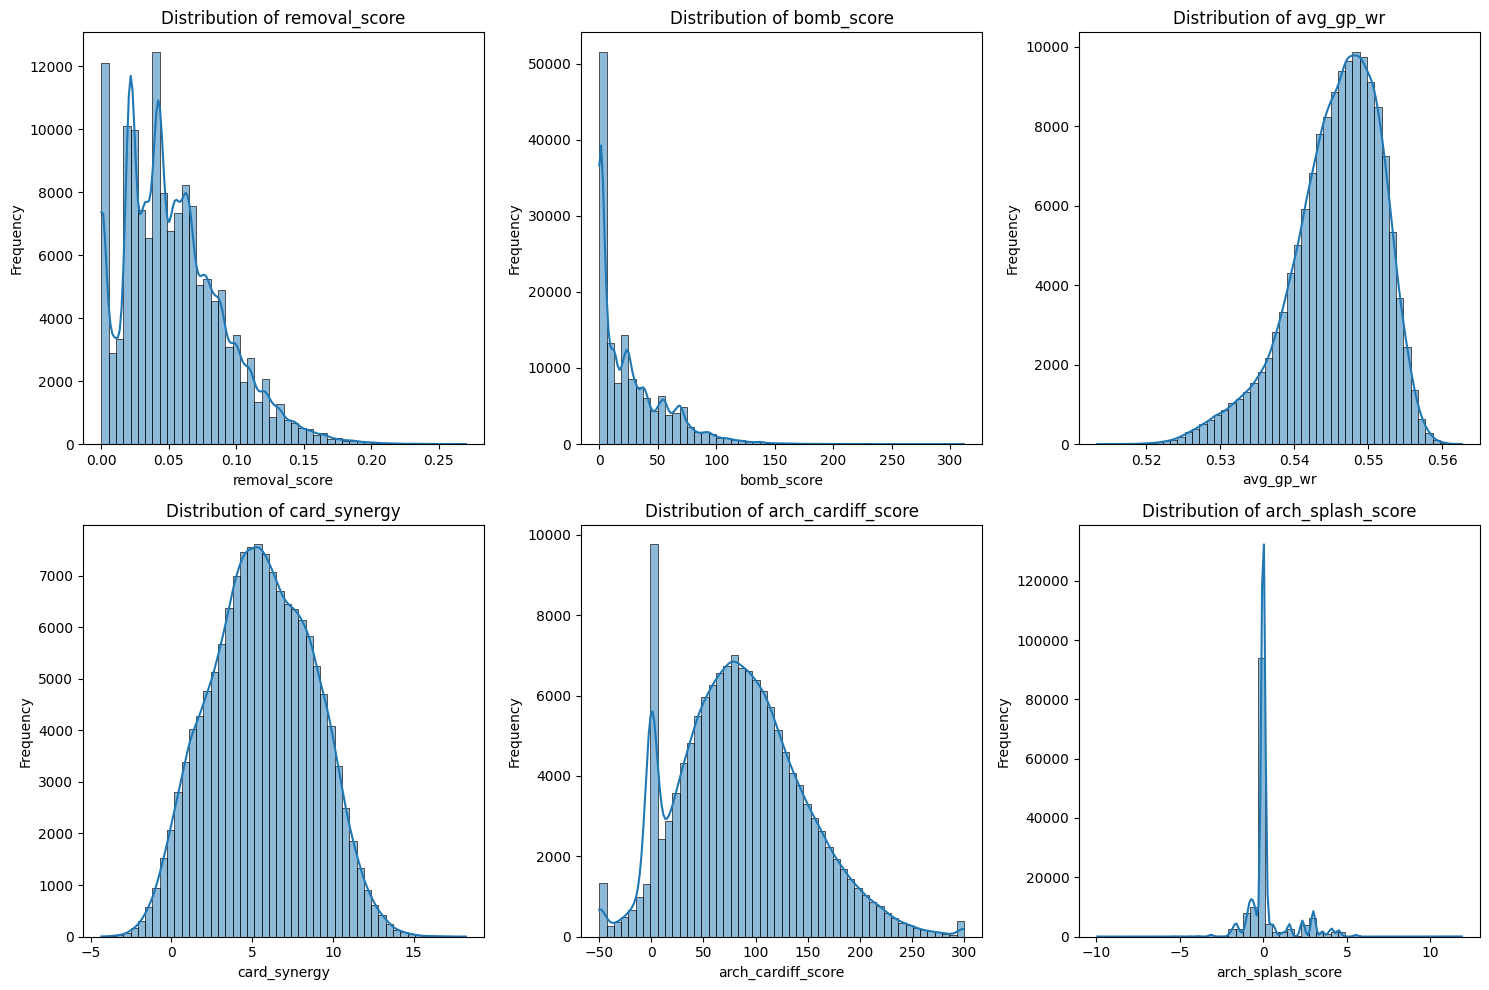

Pearson Correlation Coefficients:
removal_score: 0.0719
bomb_score: 0.1148
avg_gp_wr: 0.1728
card_synergy: 0.1151
arch_cardiff_score: 0.1717
arch_splash_score: 0.0180


In [ ]:
engineered_features = ["removal_score", "bomb_score",
                        "avg_gp_wr", "card_synergy",
                        "arch_cardiff_score", "arch_splash_score"]

# Plot histograms for feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(engineered_features):
    sns.histplot(decks_df[feature], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Compute and display Pearson correlation coefficients
pearson_results = {feature: pearsonr(decks_df[feature].reindex(y_train.index), y_train)[0] for feature in engineered_features}
print("Pearson Correlation Coefficients:")
for feature, correlation in pearson_results.items():
    print(f"{feature}: {correlation:.4f}")


In [128]:
decks_df['arch_cardiff_score'].describe()

count    143207.000000
mean         84.930222
std          79.920022
min       -1450.891376
25%          44.372111
50%          83.406607
75%         124.308930
max         971.095335
Name: arch_cardiff_score, dtype: float64

In [ ]:
decks_df["arch_cardiff_score"] = decks_df["arch_cardiff_score"].clip(-50, 300)
decks_df['arch_cardiff_score'].describe()


count    143207.000000
mean         86.556200
std          60.316655
min         -50.000000
25%          44.372111
50%          83.406607
75%         124.308930
max         300.000000
Name: arch_cardiff_score, dtype: float64

In [147]:
calc_pearson_wrcorr(decks_df, 'arch_cardiff_score')

Pearson Correlation: 0.1703
P-Value: 0.0000


In [148]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define fixed hyperparameter values
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 0.5, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

# Run randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random samples
    scoring="r2",
    cv=3,  # 3-fold cross-validation
    verbose=2
)

# Execute search
random_search.fit(X_train, y_train)

# Display best results
print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0, subsample=0.9; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=100, reg_alpha=1.0, reg_lambda=0, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators

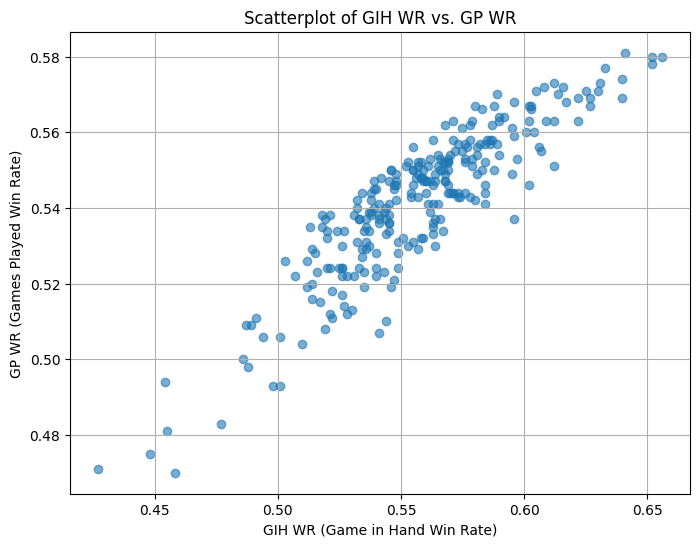

In [151]:
ratings_df["GIH WR"] = ratings_df["GIH WR"].str.rstrip("%").astype(float) / 100

# Plot scatterplot of "GIH WR" vs. "GP WR"
plt.figure(figsize=(8, 6))
plt.scatter(ratings_df["GIH WR"], ratings_df["GP WR"], alpha=0.6)
plt.xlabel("GIH WR (Game in Hand Win Rate)")
plt.ylabel("GP WR (Games Played Win Rate)")
plt.title("Scatterplot of GIH WR vs. GP WR")
plt.grid(True)

plt.show()

In [169]:
# Filter for commons and uncommons with GP WR >= 54%
filtered_ratings = ratings_df[(ratings_df["Rarity"].isin(["C", "U"])) & (ratings_df["GP WR"] >= 0.54)]

# Create a mapping of {card name: (GP WR - 0.54) ** 2}
gpwr_diff_map = {row["Name"]: ((row["GP WR"] - 0.54) * 100) for _, row in filtered_ratings.iterrows()}

# Display sample
print("Top boosted commons/uncommons:")
print(dict(list(gpwr_diff_map.items())[:10]))  # Show a few entries


Top boosted commons/uncommons:
{'Banishing Light': 1.100000000000001, 'Brightblade Stoat': 1.7999999999999905, "Builder's Talent": 0.7000000000000006, 'Carrot Cake': 2.6000000000000023, 'Crumb and Get It': 1.200000000000001, 'Driftgloom Coyote': 1.5000000000000013, 'Feather of Flight': 1.7999999999999905, 'Flowerfoot Swordmaster': 0.7000000000000006, 'Harvestrite Host': 2.9999999999999916, 'Hop to It': 2.7000000000000024}


In [171]:
# Initialize new feature column
decks_df["nonrare_diff"] = 0  

# Iterate through map and sum contributions from non-rare cards
for card_name, squared_diff in gpwr_diff_map.items():
    deck_column = f"deck_{card_name}"
    if deck_column in decks_df.columns:
        decks_df["nonrare_diff"] += decks_df[deck_column] * squared_diff


calc_pearson_wrcorr(decks_df, "nonrare_diff")

Pearson Correlation: 0.1395
P-Value: 0.0000


In [172]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in decks_df.columns if col.startswith("deck_")]
engineered_features = ["removal_score", "bomb_score",
                        "avg_gp_wr", "card_synergy",
                        "arch_cardiff_score", "arch_splash_score", "nonrare_diff"]
# Final feature list
features =  engineered_features + cmc_cols + color_cols + deck_cols

X = decks_df[features]
X_prepared = X.copy()
X_prepared[basic_land_columns] = X_prepared[basic_land_columns] / 10

X_train, X_val, y_train, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    subsample=0.8,
    reg_lambda=0,
    reg_alpha=1.0,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val)

# Evaluate model performance
r2_xgb = r2_score(y_val, y_pred)
mae_xgb = mean_absolute_error(y_val, y_pred)

print(f"XGBoost Performance:")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.4f}")


XGBoost Performance:
R² Score: 0.0804
Mean Absolute Error: 0.1742


In [173]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# List of engineered features to test
dropout_features = ["removal_score", "bomb_score", "avg_gp_wr",
                     "card_synergy", "arch_cardiff_score", "arch_splash_score"]

# Store results
dropout_results = []

# Train baseline model
xgb_baseline = XGBRegressor(
    subsample=0.8, reg_lambda=0, reg_alpha=1.0, 
    n_estimators=200, max_depth=4, learning_rate=0.1, 
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_baseline.fit(X_train, y_train)
y_pred_baseline = xgb_baseline.predict(X_val)
r2_baseline = r2_score(y_val, y_pred_baseline)
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)

# Run dropout testing
for feature in dropout_features:
    X_train_mod = X_train.drop(columns=[feature])
    X_val_mod = X_val.drop(columns=[feature])

    # Train XGBoost model with one feature removed
    xgb_model = XGBRegressor(
        subsample=0.8, reg_lambda=0, reg_alpha=1.0, 
        n_estimators=200, max_depth=4, learning_rate=0.1, 
        colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train_mod, y_train)
    y_pred_mod = xgb_model.predict(X_val_mod)

    # Evaluate performance
    r2_mod = r2_score(y_val, y_pred_mod)
    mae_mod = mean_absolute_error(y_val, y_pred_mod)

    dropout_results.append({"Dropped Feature": feature, "R² Score": r2_mod, "MAE": mae_mod})

# Convert results to DataFrame and sort by R² change
dropout_df = pd.DataFrame(dropout_results)
dropout_df["R² Change"] = dropout_df["R² Score"] - r2_baseline
dropout_df.sort_values(by="R² Change", ascending=True, inplace=True)

print("\nFeature Dropout Impact:")
print(dropout_df)



Feature Dropout Impact:
      Dropped Feature  R² Score       MAE  R² Change
3        card_synergy  0.076903  0.174556  -0.003537
4  arch_cardiff_score  0.079288  0.174212  -0.001152
0       removal_score  0.080581  0.174162   0.000142
1          bomb_score  0.080723  0.174138   0.000284
5   arch_splash_score  0.080923  0.174120   0.000484
2           avg_gp_wr  0.081175  0.174127   0.000735


In [174]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# List of engineered features to test
dropout_features = ["removal_score", "bomb_score",
                     "card_synergy", "arch_cardiff_score", "arch_splash_score"]

# Store results
dropout_results = []

# Train baseline model
xgb_baseline = XGBRegressor(
    subsample=0.8, reg_lambda=0, reg_alpha=1.0, 
    n_estimators=200, max_depth=4, learning_rate=0.1, 
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_baseline.fit(X_train, y_train)
y_pred_baseline = xgb_baseline.predict(X_val)
r2_baseline = r2_score(y_val, y_pred_baseline)
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)

# Run dropout testing
for feature in dropout_features:
    X_train_mod = X_train.drop(columns=[feature])
    X_val_mod = X_val.drop(columns=[feature])

    # Train XGBoost model with one feature removed
    xgb_model = XGBRegressor(
        subsample=0.8, reg_lambda=0, reg_alpha=1.0, 
        n_estimators=200, max_depth=4, learning_rate=0.1, 
        colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train_mod, y_train)
    y_pred_mod = xgb_model.predict(X_val_mod)

    # Evaluate performance
    r2_mod = r2_score(y_val, y_pred_mod)
    mae_mod = mean_absolute_error(y_val, y_pred_mod)

    dropout_results.append({"Dropped Feature": feature, "R² Score": r2_mod, "MAE": mae_mod})

# Convert results to DataFrame and sort by R² change
dropout_df = pd.DataFrame(dropout_results)
dropout_df["R² Change"] = dropout_df["R² Score"] - r2_baseline
dropout_df.sort_values(by="R² Change", ascending=True, inplace=True)

print("\nFeature Dropout Impact:")
print(dropout_df)



Feature Dropout Impact:
      Dropped Feature  R² Score       MAE  R² Change
2        card_synergy  0.076903  0.174556  -0.003537
3  arch_cardiff_score  0.079288  0.174212  -0.001152
0       removal_score  0.080581  0.174162   0.000142
1          bomb_score  0.080723  0.174138   0.000284
4   arch_splash_score  0.080923  0.174120   0.000484


In [ ]:
#TODO for tomorrow - fix the color column feature
# add rank correction